# 第8週：China FUD twitter相關推文之詞彙關係

Author: 蘇舫萱  
Date created: 2021/10/03
Last modified: 2021/10/03

本週課程為「文辭和文件分析、文件格式的互通」，目的為了解文辭和文件分析的技巧。文辭和文件分析的步驟會因所要分析之語言不同而有所差異，在這個Jupyter Notebook當中將會展示「英文」的情緒分析，並且搭配python程式碼進行講解。在後面的內容中，我們將會介紹所使用到的套件、資料前處理、TF-IDF、N-gram。

- **基本資料介紹**
    - 資料來源: twitter 2021-09-24 ~ 2021-09-25文章
    - 關鍵字：China FUD
    - 資料時間：2021-09-24 ~ 2021-09-25
- **1. 資料前處理**
    - 資料清理
    - 文章斷詞與整理
- **2. TF-IDF**
    - 計算每篇文章的詞數
    - 合併需要的資料欄位
    - 計算tf-idf值
    - 檢視結果
- **3. 透過結巴斷詞與N-gram幫助建立字典**
    - Bigram
    - Trigram
- **4. 建立Ngram預測模型**
- **5. Bigram視覺化**
- **6. Pairwise correlation**
    - 找出相關性高的詞彙
    - 畫出關係圖
    
> **事件介紹**  
**9/24**  
中國人民銀行在官網上明確指出加密或幣相關交易將會被視為是「非法金融活動」，也會制止任何挖礦行為，是中國對幣圈迄今最嚴厲且全面的措施。

> **FUD（Fear, Uncertainty, and Doubt；恐懼、不確定性和懷疑）**  
是幣圈術語，也就是投資者對未知的前景和負面消息感到恐懼的意思。  
FUD 主要是散佈關於某些事物的任何虛假資訊、從而誤導大眾，甚至因此令資產價格因為虛假或錯誤資訊而下跌。  
所以，中國封殺比特幣就被稱為「China FUD」。

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import re
import nltk
#nltk.download("punkt")
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from datetime import datetime
from wordcloud import WordCloud 
import math
from nltk import ngrams
from collections import defaultdict
from nltk import FreqDist
from collections import Counter, namedtuple
import networkx as nx

## 基本資料介紹
- 資料來源: twitter 2021-09-24 ~ 2021-09-25文章
- 資料集： tweets.csv
- 關鍵字：China FUD
- 資料時間：2021-09-24 ~ 2021-09-25
- 資料筆數：共 3000 篇文章

In [2]:
#匯入資料
MetaData = pd.read_csv('./data/tweets2.csv')

In [3]:
MetaData.head(3)

,created_at,status_id,user_id,user_name,text,favourites,retweet,source
0,2021-09-25 08:55:09,1441687708783415298,AntBallard1,Antony Ballard,@cryptan48665041 @tomskiweb FUD. Same old Chin...,0,0,Twitter for iPhone
1,2021-09-25 08:51:57,1441686903204585472,CatherineMugari,Cathy mugs,@IOHK_Charles China is buying thr own FUD nxaa,0,0,Twitter for Android
2,2021-09-25 08:51:52,1441686880240783360,TheReal_KDubb,K Dubb,Bitcoin Maintains $42K Amid the China FUD: Car...,0,0,Twitter Web App


In [4]:
#增加ID
MetaData = MetaData.assign(art_id = MetaData.index)

## 1. 資料前處理

### (1) 資料清理  
- 去除特殊字元與標點符號

In [5]:
def clean(row): 
    text = re.sub('[\t]{2,}', '', row) #去除兩個以上空格或tab
    text = re.sub('(http|https)://.*', '', text) #去除網址(.:任意字元，*:0次以上)
    text = re.sub('&.*;', '', text) #去除html特殊字元編碼
    text = re.sub('#_*', '', text) #去除一個或多個_
    text = re.sub('\\n', ' ', text) #去除換行
    text = re.sub('\.|,', ' ', text) #替代.,
    text = re.sub('\s{2,}', ' ', text) #去除多個空格(+:一次以上)
    text = re.sub('^\\s+|\\s+$', '', text) #去除開頭/結尾有一個或多個空格
    text = re.sub('[^a-zA-Z ]', '', text) #除了字母,空白?!.的都去掉(表情符號去掉)
    return text

In [6]:
MetaData['text'] = MetaData.text.apply(clean)
MetaData.head(3)

,created_at,status_id,user_id,user_name,text,favourites,retweet,source,art_id
0,2021-09-25 08:55:09,1441687708783415298,AntBallard1,Antony Ballard,cryptan tomskiweb FUD Same old China crackdown...,0,0,Twitter for iPhone,0
1,2021-09-25 08:51:57,1441686903204585472,CatherineMugari,Cathy mugs,IOHKCharles China is buying thr own FUD nxaa,0,0,Twitter for Android,1
2,2021-09-25 08:51:52,1441686880240783360,TheReal_KDubb,K Dubb,Bitcoin Maintains K Amid the China FUD Cardano...,0,0,Twitter Web App,2


### (2) 文章斷詞與整理

In [7]:
##新增stop words
nltk.download('stopwords')
stopWords = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# 設定斷詞 function
stemmer = PorterStemmer() #做Stemming還原詞幹
def getToken(row):
    seg_list = nltk.tokenize.word_tokenize(row)
    seg_list = [stemmer.stem(str(w)).lower() for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = [w for w in seg_list if w not in stopWords]
    return seg_list

In [9]:
data = MetaData.copy()
data['word'] = data.text.apply(getToken)
data = data.explode('word')
data.reset_index(inplace=True, drop=True) #重設index
data.head()

,created_at,status_id,user_id,user_name,text,favourites,retweet,source,art_id,word
0,2021-09-25 08:55:09,1441687708783415298,AntBallard1,Antony Ballard,cryptan tomskiweb FUD Same old China crackdown...,0,0,Twitter for iPhone,0,cryptan
1,2021-09-25 08:55:09,1441687708783415298,AntBallard1,Antony Ballard,cryptan tomskiweb FUD Same old China crackdown...,0,0,Twitter for iPhone,0,tomskiweb
2,2021-09-25 08:55:09,1441687708783415298,AntBallard1,Antony Ballard,cryptan tomskiweb FUD Same old China crackdown...,0,0,Twitter for iPhone,0,fud
3,2021-09-25 08:55:09,1441687708783415298,AntBallard1,Antony Ballard,cryptan tomskiweb FUD Same old China crackdown...,0,0,Twitter for iPhone,0,old
4,2021-09-25 08:55:09,1441687708783415298,AntBallard1,Antony Ballard,cryptan tomskiweb FUD Same old China crackdown...,0,0,Twitter for iPhone,0,china


In [10]:
#計算各詞彙在各文章中出現的次數
word_count = data.groupby(["art_id","word"],as_index=False).size()
word_count.rename(columns={'size': 'count'}, inplace=True)

In [11]:
word_count

,art_id,word,count
0,0,ban,1
1,0,china,1
2,0,crackdown,1
3,0,cryptan,1
4,0,crypto,1
...,...,...,...
27725,2999,im,1
27726,2999,issu,1
27727,2999,li,1
27728,2999,press,1


## 2. TF-IDF
### (1) 計算每篇文章的詞數

In [12]:
total_words = data.groupby(['art_id'],as_index=False).size()
total_words.rename(columns={'size': 'total'}, inplace=True)
total_words

,art_id,total
0,0,13
1,1,6
2,2,11
3,3,7
4,4,10
...,...,...
2995,2995,9
2996,2996,12
2997,2997,6
2998,2998,6


### (2) 合併需要的資料欄位
- 合併 **每個詞彙在每個文章中出現的次數** 與 **每篇文章的詞數**
- 新增各個詞彙在所有詞彙中的總數欄位

In [13]:
fud_words = word_count.merge(total_words,on = 'art_id',how = 'left')
fud_words.head(10)

,art_id,word,count,total
0,0,ban,1,13
1,0,china,1,13
2,0,crackdown,1,13
3,0,cryptan,1,13
4,0,crypto,1,13
5,0,fail,1,13
6,0,fud,1,13
7,0,news,1,13
8,0,old,1,13
9,0,tomskiweb,1,13


### (3) 計算 tf-idf 值
- 以每篇文章爲單位，計算每個詞彙的 tf-idf 值  
    - TF (Term Frequency):某一個詞彙在某一個文件中所出現的頻率。  
        詞彙在該文件中出現次數 / 該文件中詞彙總數  
    - IDF (Inverse Document Frequent):為文件數除以某特定詞彙有被多少文件所提及的數量取log  
        log( 總文件數量 / 包含該詞彙的文件數量 ) 

In [14]:
#計算tf
fud_words_tf_idf = fud_words.assign(tf = fud_words.iloc[:,2]/fud_words.iloc[:,3])

In [15]:
# 計算每個詞彙出現在幾篇文章中
idf_df = fud_words.groupby(['word'],as_index=False).size()
fud_words_tf_idf = fud_words_tf_idf.merge(idf_df,on = 'word',how = 'left')

In [16]:
#計算idf
fud_words_tf_idf = fud_words_tf_idf.assign(idf = fud_words_tf_idf.iloc[:,5]
                                               .apply(lambda x: math.log((len(total_words)/x),10)))

fud_words_tf_idf = fud_words_tf_idf.drop(labels=['size'],axis=1)

In [17]:
#計算tf*idf
fud_words_tf_idf = fud_words_tf_idf.assign(tf_idf = fud_words_tf_idf.iloc[:,4]*fud_words_tf_idf.iloc[:,5])

In [18]:
fud_words_tf_idf.head(10)

,art_id,word,count,total,tf,idf,tf_idf
0,0,ban,1,13,0.076923,0.844664,0.064974
1,0,china,1,13,0.076923,0.042872,0.003298
2,0,crackdown,1,13,0.076923,2.134699,0.164208
3,0,cryptan,1,13,0.076923,3.477121,0.267471
4,0,crypto,1,13,0.076923,0.630784,0.048522
5,0,fail,1,13,0.076923,2.477121,0.190548
6,0,fud,1,13,0.076923,0.067865,0.005220
7,0,news,1,13,0.076923,1.219443,0.093803
8,0,old,1,13,0.076923,1.532639,0.117895
9,0,tomskiweb,1,13,0.076923,2.875061,0.221159


#### 檢視結果

In [19]:
# 選出每篇文章，tf-idf值最大的五個詞
group = fud_words_tf_idf.groupby("art_id").apply(lambda x : x.nlargest(5, "tf_idf"))

In [20]:
group.loc[:,["word","tf_idf"]][0:15]

word    tf_idf
art_id                        
0      3     cryptan  0.267471
       9   tomskiweb  0.221159
       5        fail  0.190548
       10    without  0.179307
       11       year  0.177677
1      16       nxaa  0.579520
       17        thr  0.579520
       15  iohkcharl  0.383505
       12        buy  0.184342
       14        fud  0.011311
2      18       amid  0.195900
       24   maintain  0.195900
       25       onli  0.190628
       20    cardano  0.189016
       27      watch  0.187468

#### 計算整個文集中較常 tf-idf 值高的字

In [21]:
# 從每篇文章挑選出tf-idf最大的十個詞
(fud_words_tf_idf.groupby("art_id").apply(lambda x : x.nlargest(10, "tf_idf")).reset_index(drop=True)
# 計算每個詞被選中的次數
.groupby(['word'],as_index=False).size()
).sort_values('size', ascending=False).head(10) #排序看前十名

,word,size
1564,fud,1883
676,china,1717
898,crypto,544
386,bitcoin,487
280,ban,363
3788,time,356
514,btc,327
4211,year,205
561,buy,203
2159,last,191


## 3. 透過結巴斷詞與N-gram幫助建立字典

In [22]:
token = nltk.tokenize.word_tokenize("What A Beautiful Day")
token

['What', 'A', 'Beautiful', 'Day']

In [23]:
bigram  = ngrams(token, 2)

In [24]:
list(bigram)

[('What', 'A'), ('A', 'Beautiful'), ('Beautiful', 'Day')]

### Bigram

In [25]:
# 設定 bigram 斷詞 function
def bigram_getToken(row):
    seg_list = nltk.tokenize.word_tokenize(row)
    seg_list = [stemmer.stem(str(w)).lower() for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = [w for w in seg_list if w not in stopWords]
    seg_list = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [26]:
fud_bigram = MetaData.copy()
fud_bigram["word"] = fud_bigram.text.apply(bigram_getToken)
fud_bigram = fud_bigram.explode('word')
fud_bigram.head(3)

,created_at,status_id,user_id,user_name,text,favourites,retweet,source,art_id,word
0,2021-09-25 08:55:09,1441687708783415298,AntBallard1,Antony Ballard,cryptan tomskiweb FUD Same old China crackdown...,0,0,Twitter for iPhone,0,cryptan tomskiweb
0,2021-09-25 08:55:09,1441687708783415298,AntBallard1,Antony Ballard,cryptan tomskiweb FUD Same old China crackdown...,0,0,Twitter for iPhone,0,tomskiweb fud
0,2021-09-25 08:55:09,1441687708783415298,AntBallard1,Antony Ballard,cryptan tomskiweb FUD Same old China crackdown...,0,0,Twitter for iPhone,0,fud old


#### 統計最常出現的bigram組合

In [27]:
# 計算每個組合出現的次數
fud_bigram_count = fud_bigram.groupby(["word"],as_index=False).size()

In [28]:
# 清除包含數字的bigram組合
wb_filter = list(fud_bigram_count["word"].apply(lambda x: True if not re.search("[0-9]",x) else False))
fud_bigram_count[wb_filter].sort_values(by=['size'], ascending=False).head(15)

,word,size
2583,china fud,1831
2487,china ban,217
11376,recov china,143
3589,crypto recov,143
8101,last year,141
5726,fud china,141
13677,time last,139
4496,dozen time,139
5805,fud dozen,119
934,ban crypto,96


### Trigram

In [29]:
# 設定 trigram 斷詞 function
def trigram_getToken(row):
    seg_list = nltk.tokenize.word_tokenize(row)
    seg_list = [stemmer.stem(str(w)).lower() for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = [w for w in seg_list if w not in stopWords]
    seg_list = ngrams(seg_list, 3)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [30]:
fud_trigram = MetaData.copy()
fud_trigram["word"] = fud_trigram.text.apply(trigram_getToken)
fud_trigram = fud_trigram.explode('word')
fud_trigram.head(3)

,created_at,status_id,user_id,user_name,text,favourites,retweet,source,art_id,word
0,2021-09-25 08:55:09,1441687708783415298,AntBallard1,Antony Ballard,cryptan tomskiweb FUD Same old China crackdown...,0,0,Twitter for iPhone,0,cryptan tomskiweb fud
0,2021-09-25 08:55:09,1441687708783415298,AntBallard1,Antony Ballard,cryptan tomskiweb FUD Same old China crackdown...,0,0,Twitter for iPhone,0,tomskiweb fud old
0,2021-09-25 08:55:09,1441687708783415298,AntBallard1,Antony Ballard,cryptan tomskiweb FUD Same old China crackdown...,0,0,Twitter for iPhone,0,fud old china


#### 統計最常出現的trigram組合

In [31]:
# 計算每個組合出現的次數
fud_trigram_count = fud_trigram.groupby(["word"],as_index=False).size()
# 清除包含數字的trigram組合
wb_filter = list(fud_trigram_count["word"].apply(lambda x: True if not re.search("[0-9]",x) else False))
fud_trigram_count[wb_filter].sort_values(by=['size'], ascending=False).head(10)

,word,size
13715,recov china fud,143
4870,crypto recov china,142
5845,dozen time last,137
16105,time last year,135
7489,fud dozen time,119
3215,china fud dozen,119
2858,china ban crypto,76
2851,china ban bitcoin,56
2986,china crypto ban,38
3145,china fud buy,29


從上面的 bigram 和 trigram 的結果中，我們發現有些字較常一起出現。  

## 4. 建立Ngram預測模型

In [33]:
data2 = MetaData.copy()
sen_tokens = data2.text.apply(getToken).tolist()

In [34]:
def ngram(documents, N=2):
    ngram_prediction = dict()
    total_grams = list()
    words = list()
    Word = namedtuple('Word', ['word', 'prob'])

    for doc in documents:
        #加上開頭和結尾 tag
        split_words = ['<s>'] + list(doc) + ['</s>']
        # 計算分子
        [total_grams.append(tuple(split_words[i:i+N])) for i in range(len(split_words)-N+1)]
        # 計算分母
        [words.append(tuple(split_words[i:i+N-1])) for i in range(len(split_words)-N+2)]
        
    total_word_counter = Counter(total_grams)
    word_counter = Counter(words)
    
    for key in total_word_counter:
        word = ''.join(key[:N-1])
        if word not in ngram_prediction:
            ngram_prediction.update({word: set()})
            
        next_word_prob = total_word_counter[key]/word_counter[key[:N-1]] #P(B|A)
        w = Word(key[-1], '{:.3g}'.format(next_word_prob))
        ngram_prediction[word].add(w)
        
    return ngram_prediction

In [37]:
#Bigram預測模型為例
bi_prediction = ngram(sen_tokens, N=2)

In [38]:
bi_prediction

{'<s>': {Word(word='spread', prob='0.000333'),
  Word(word='impress', prob='0.000333'),
  Word(word='luigidemeo', prob='0.000333'),
  Word(word='theta', prob='0.000333'),
  Word(word='yo', prob='0.000333'),
  Word(word='cryptocevo', prob='0.000333'),
  Word(word='axia', prob='0.000333'),
  Word(word='mainstream', prob='0.000333'),
  Word(word='girlgonecrypto', prob='0.000667'),
  Word(word='respons', prob='0.000667'),
  Word(word='ecomiburn', prob='0.000333'),
  Word(word='goodsoupyo', prob='0.000333'),
  Word(word='dwr', prob='0.000333'),
  Word(word='beniaminmincu', prob='0.000333'),
  Word(word='dylanleclair', prob='0.001'),
  Word(word='tradersz', prob='0.002'),
  Word(word='truecrypto', prob='0.000333'),
  Word(word='easyeight', prob='0.000333'),
  Word(word='chairnft', prob='0.000333'),
  Word(word='jonnybnft', prob='0.000333'),
  Word(word='goingparabol', prob='0.000667'),
  Word(word='incomeshark', prob='0.000333'),
  Word(word='fud', prob='0.00733'),
  Word(word='see', prob='0

In [62]:
#預測下一個出現的詞
text = 'china'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: fud, probability: 0.628
next word: ban, probability: 0.0744
next word: crypto, probability: 0.0233
next word: </s>, probability: 0.0206
next word: bitcoin, probability: 0.0127


In [63]:
text = 'bitcoin'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: </s>, probability: 0.134
next word: fud, probability: 0.0799
next word: price, probability: 0.0555
next word: china, probability: 0.0489
next word: rollercoast, probability: 0.044


## 5. bigram視覺化

In [45]:
#根據剛剛的觀察可以增加stopwords
stopWords.append('th')

In [46]:
# 另一種方式 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist()
def bigram_getToken_dict(row):
    text = re.sub('[0-9]', '', str(row))
    seg_list = nltk.tokenize.word_tokenize(text)
    seg_list = [stemmer.stem(str(w)).lower() for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = [w for w in seg_list if w not in stopWords]
    bigramfdist.update(ngrams(seg_list, 2))
    seg_list2 = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list2)]
    return seg_list

In [47]:
fud_bigram2 = MetaData.copy()
fud_bigram2["word"] = fud_bigram2.text.apply(bigram_getToken_dict)
fud_bigram2 = fud_bigram2.explode('word')
# fud_bigram2.head(3)

,created_at,status_id,user_id,user_name,text,favourites,retweet,source,art_id,word
0,2021-09-25 08:55:09,1441687708783415298,AntBallard1,Antony Ballard,cryptan tomskiweb FUD Same old China crackdown...,0,0,Twitter for iPhone,0,cryptan tomskiweb
0,2021-09-25 08:55:09,1441687708783415298,AntBallard1,Antony Ballard,cryptan tomskiweb FUD Same old China crackdown...,0,0,Twitter for iPhone,0,tomskiweb fud
0,2021-09-25 08:55:09,1441687708783415298,AntBallard1,Antony Ballard,cryptan tomskiweb FUD Same old China crackdown...,0,0,Twitter for iPhone,0,fud old


In [48]:
#建立bigram和count的dictionary
#這裡取最多的前30項
d = {k:v for k,v in bigramfdist.most_common(30)}

In [49]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v)
    
# 取得edge權重
weights = [w[2]['weight']*0.05 for w in  G.edges(data=True)]

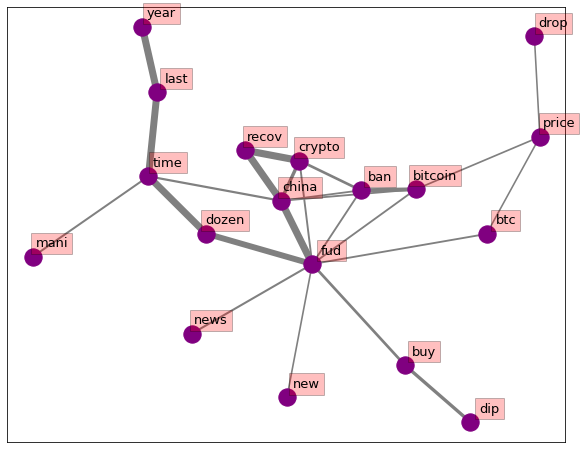

In [52]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

## 6. Pairwise correlation
計算兩個詞彙間的相關性 Phi相關係數(Phi coefficient)  
<img src="./img/pic1.png" style="float:left;" width="50%">  
<img src="./img/pic2.png" style="float:left;" width="25%">

In [55]:
#取常一起出現的bigram pair 前500筆
b = {k:v for k,v in bigramfdist.most_common(500)}
# b.items()

In [56]:
#建立DataFrame
bigram_df = pd.DataFrame(columns=['word', 'word2','n'])
for k,v in b.items():
    bigram_df = bigram_df.append({'word':k[0], 'word2':k[1], 'n':v}, ignore_index=True)

In [57]:
bigram_df.head()

,word,word2,n
0,china,fud,1831
1,china,ban,217
2,crypto,recov,143
3,recov,china,143
4,fud,china,142


In [62]:
#計算phi值
def phi_cor(df):
    #total x
    nx = len(set(word_count[word_count["word"]==df["word"]]["art_id"]))
    tnx = len(MetaData)-nx
    #total y
    ny = len(set(word_count[word_count["word"]==df["word2"]]["art_id"]))
    tny = len(MetaData)-ny
    #有x 有y
    x_ls = list(word_count[word_count["word"]==df["word"]]["art_id"]) #單獨有x
    y_ls = list(word_count[word_count["word"]==df["word2"]]["art_id"]) #單獨有y
    nxy = len(set(x_ls)&set(y_ls)) #取交集
    #有x 沒有y
    nxo = nx-nxy
    #沒有x 沒有y
    uxy = set(x_ls)|set(y_ls) #取聯集
    noo = len(set(list(MetaData["art_id"]))-uxy) #取差集:全-有x有y
    #沒有x 有y
    noy = ny-nxy
    #print(nx,ny,tny,tnx,nxy,noo,nxo,noy)
    phi = (nxy*noo-nxo*noy)/math.sqrt(nx*ny*tny*tnx)
    
    return phi

In [63]:
bigram_df["cor"] = bigram_df.apply(phi_cor, axis=1)
bigram_df = bigram_df[bigram_df["word"]!=bigram_df["word2"]]

In [64]:
bigram_df

,word,word2,n,cor
0,china,fud,1831,0.604627
1,china,ban,217,0.111999
2,crypto,recov,143,0.385673
3,recov,china,143,0.063997
4,fud,china,142,0.604627
...,...,...,...,...
495,whole,china,4,0.020413
496,break,china,4,0.009413
497,best,buy,4,0.055155
498,fud,becom,4,0.010403


### 和 china, bitcoin 相關性最高的 15 個詞彙

In [65]:
c_sum = bigram_df[(bigram_df["word"]=="china")].sort_values(by=['cor'], ascending = False).head(15)
b_sum = bigram_df[(bigram_df["word"]=="bitcoin")].sort_values(by=['cor'], ascending = False).head(15)

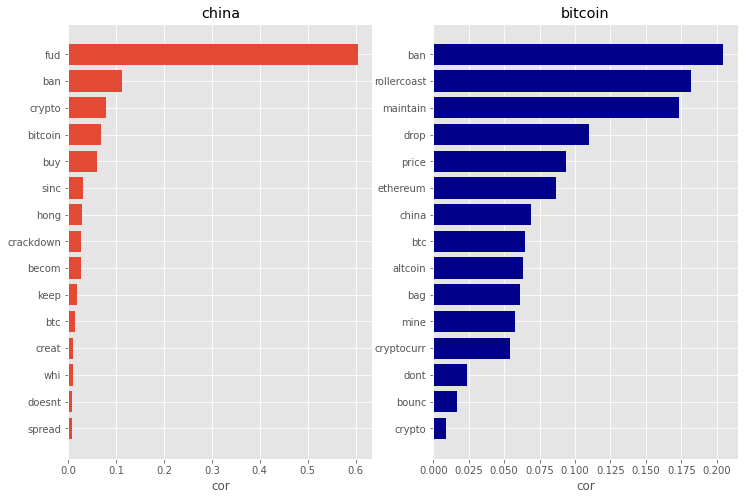

In [66]:
c_sum = c_sum.sort_values(by=['cor'])
b_sum = b_sum.sort_values(by=['cor'])

plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
# plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('china')
plt.xlabel('cor')
plt.barh(c_sum['word2'],c_sum['cor'])

plt.subplot(122)
plt.title('bitcoin')
plt.xlabel('cor')
plt.barh(b_sum['word2'],b_sum['cor'],color="darkblue")


plt.show()

### 使用詞彙關係圖畫出相關性大於0.4的組合

In [67]:
word_cors = bigram_df[bigram_df["cor"]>0.4]
word_cors.reset_index(inplace=True, drop=True)

In [68]:
word_cors.head()

,word,word2,n,cor
0,china,fud,1831,0.604627
1,fud,china,142,0.604627
2,last,year,141,0.699337
3,dozen,time,139,0.569566
4,time,last,139,0.530383


In [69]:
import networkx as nx
# Create network plot 
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(word_cors)):
    g.add_edge(word_cors["word"][i], word_cors["word2"][i], weight=word_cors["cor"][i])
    
# 取得edge權重
weights = [w[2]['weight']*8 for w in  g.edges(data=True)]

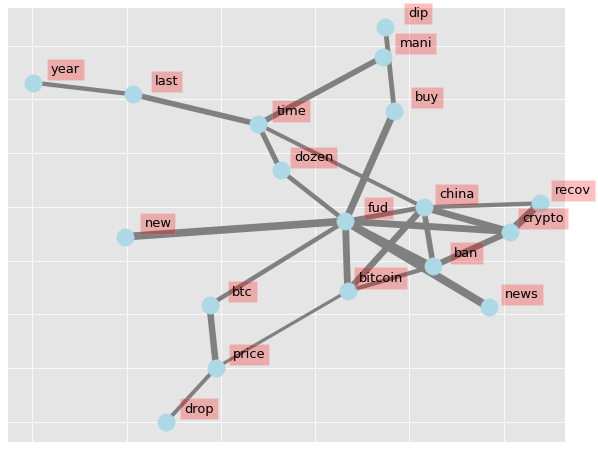

In [70]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()